In [62]:
import matplotlib.pyplot as plt 
import numpy as np              
import pandas as pd      
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import cv2

import os

In [21]:
# giving the path of the data

# for train data
train_path = './dices'
#for test data 
test_path = './dice_test'

batch_size = 16 

img_width = 128
img_height = 128


In [3]:
img_gen = ImageDataGenerator(
         rescale = 1./255,
         zoom_range = 0.2 )

test_img_gen = ImageDataGenerator(rescale = 1./255)

In [22]:
train = img_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )


test = test_img_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )


Found 6402 images belonging to 2 classes.
Found 419 images belonging to 2 classes.
Found 382 images belonging to 2 classes.


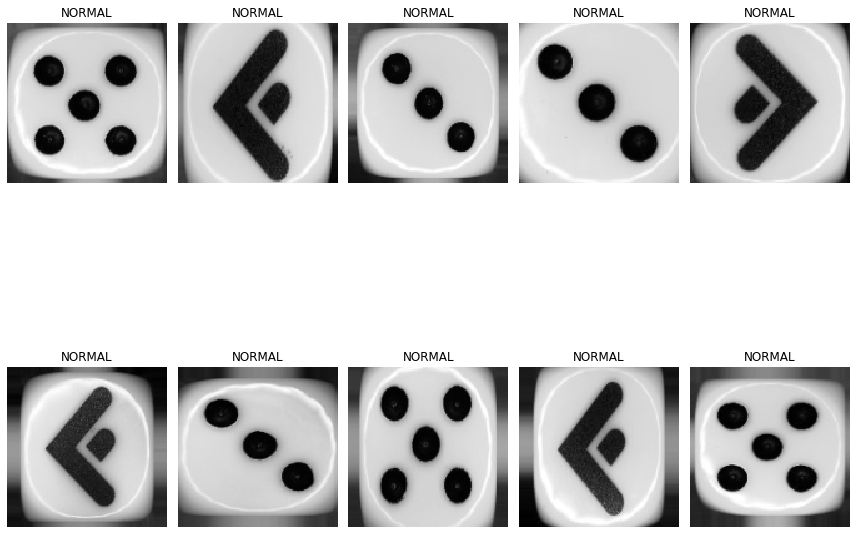

In [5]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'ABNORMAL', 1:'NORMAL'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()


In [42]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(activation = 'relu', units = 128))
    model.add(Dense(activation = 'relu', units = 64))
    model.add(Dense(activation = 'sigmoid', units = 1))
    
    opt = Adam(lr=0.000001)
    model.compile(optimizer = opt ,loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model


In [43]:
# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)      

In [54]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, monitor='val_loss')]


In [47]:
history = model.fit(train, epochs = 25 , validation_data = test, callbacks = callbacks)


Epoch 1/25
401/401 [==============================] - 39s 96ms/step - loss: 0.6835 - accuracy: 0.8247 - val_loss: 0.6756 - val_accuracy: 0.8639
Epoch 2/25
401/401 [==============================] - 40s 100ms/step - loss: 0.6533 - accuracy: 0.9531 - val_loss: 0.6478 - val_accuracy: 0.8639
Epoch 3/25
401/401 [==============================] - 43s 107ms/step - loss: 0.6073 - accuracy: 0.9531 - val_loss: 0.6043 - val_accuracy: 0.8639
Epoch 4/25
401/401 [==============================] - 41s 102ms/step - loss: 0.5359 - accuracy: 0.9531 - val_loss: 0.5416 - val_accuracy: 0.8639
Epoch 5/25
401/401 [==============================] - 40s 99ms/step - loss: 0.4421 - accuracy: 0.9531 - val_loss: 0.4739 - val_accuracy: 0.8639
Epoch 6/25
401/401 [==============================] - 42s 104ms/step - loss: 0.3466 - accuracy: 0.9531 - val_loss: 0.4228 - val_accuracy: 0.8639
Epoch 7/25
401/401 [==============================] - 41s 102ms/step - loss: 0.2700 - accuracy: 0.9531 - val_loss: 0.4007 - val_accu

<AxesSubplot:>

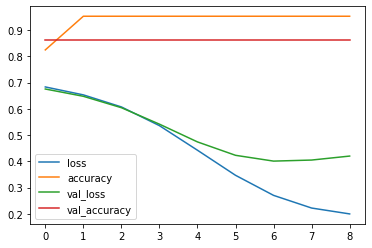

In [48]:
pd.DataFrame(history.history).plot()


In [57]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'cp.ckpt'

In [59]:
# Re-evaluate the model
loss, acc = model.evaluate(test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

24/24 - 0s - loss: 0.4199 - accuracy: 0.8639 - 442ms/epoch - 18ms/step
Restored model, accuracy: 86.39%


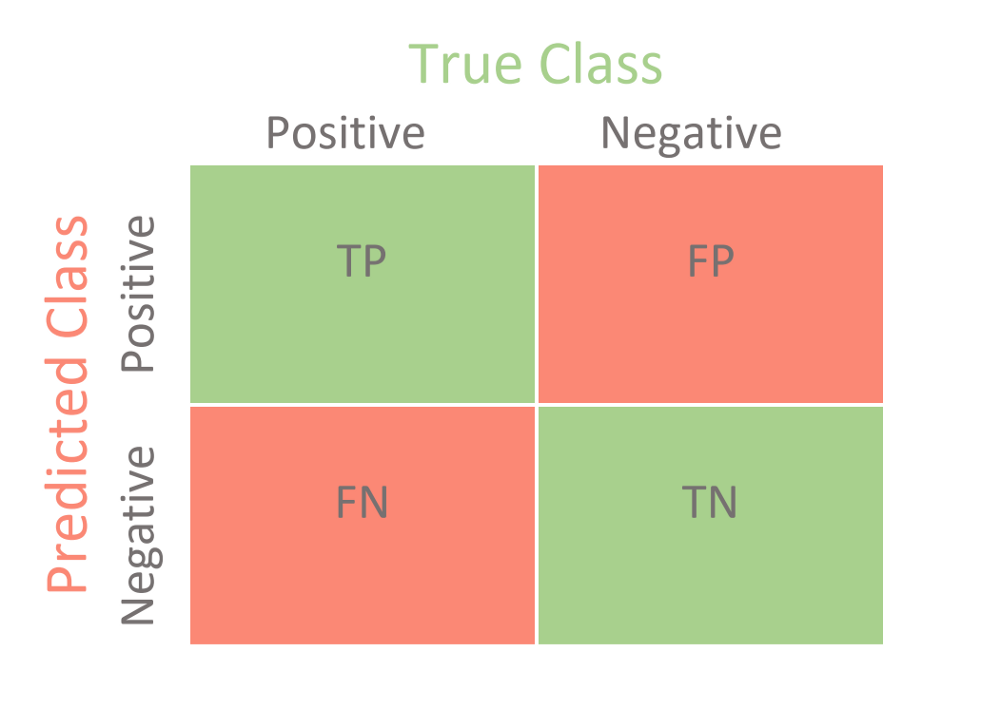



- Precision = TruePositives / (TruePositives + FalsePositives)
- Recall = TruePositives / (TruePositives + FalseNegatives)
- F1 = (2 * Precision * Recall) / (Precision + Recall)

In [20]:

print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['Abnormal','Normal']))

              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00        52
      Normal       0.86      1.00      0.93       330

    accuracy                           0.86       382
   macro avg       0.43      0.50      0.46       382
weighted avg       0.75      0.86      0.80       382



/Users/yusufakcakaya/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yusufakcakaya/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yusufakcakaya/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [102]:
prediction_path = './prediction'


In [103]:
pr = test_img_gen.flow_from_directory(
      prediction_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

Found 1 images belonging to 1 classes.


In [104]:
my_image = preprocess_input(pr)

#make the prediction
prediction = model.predict(my_image)

TypeError: '>=' not supported between instances of 'tuple' and 'int'

In [95]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

#load the image
my_image = load_img(img_path, target_size=(128, 128,1))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = model.predict(my_image)

In [99]:

#make the prediction
prediction = model.predict(my_image)

ValueError: Unsupported image shape: (1, 128, 128, 3)

In [ ]:
image = img_gen(
      img,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

In [37]:
from keras.models import load_model

saved_model = load_model('best_model.h5')
train_acc = saved_model.evaluate(train, verbose=0)
test_acc = saved_model.evaluate(test, verbose=0)

In [36]:
train_acc

[0.21617479622364044, 0.9531396627426147]

In [38]:
test_acc

[0.4017834961414337, 0.8638743162155151]